In [1]:
# ============================================
# CELL 1: Import Libraries
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine Learning libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

import warnings
warnings.filterwarnings('ignore')

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Define paths
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    PROJECT_ROOT = current_dir.parent
else:
    PROJECT_ROOT = current_dir
    
DATA_DIR = PROJECT_ROOT / 'Data'
RESULTS_DIR = PROJECT_ROOT / 'results' / 'figures'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Libraries imported successfully!")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Results directory: {RESULTS_DIR}")

✅ Libraries imported successfully!
📁 Data directory: /Users/erfanesfahanian/Desktop/audio pattern project/Data
📁 Results directory: /Users/erfanesfahanian/Desktop/audio pattern project/results/figures


KMeans = K-means clustering algorithm
PCA = Principal Component Analysis (dimensionality reduction)
silhouette_score = Measure of cluster quality
adjusted_rand_score = Compare clusters to true labels

In [2]:
# ============================================
# CELL 2: Load Data
# ============================================

# Load the 30-second features
df = pd.read_csv(DATA_DIR / 'features_30_sec.csv')

print("📊 DATASET OVERVIEW")
print("="*60)
print(f"Total samples: {len(df)}")
print(f"Total features: {df.shape[1]}")
print(f"Genres: {sorted(df['label'].unique())}")

# Separate features and labels
X = df.drop(['filename', 'label'], axis=1)
y = df['label']

print(f"\n✅ Data loaded:")
print(f"   Features shape: {X.shape}")
print(f"   Labels shape: {y.shape}")

# Normalize features (very important for k-means!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Features normalized:")
print(f"   Mean: {X_scaled.mean():.4f} (should be ~0)")
print(f"   Std: {X_scaled.std():.4f} (should be ~1)")

📊 DATASET OVERVIEW
Total samples: 1000
Total features: 60
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

✅ Data loaded:
   Features shape: (1000, 58)
   Labels shape: (1000,)

✅ Features normalized:
   Mean: -0.0000 (should be ~0)
   Std: 1.0000 (should be ~1)


What this does:

Loads same data as before
Separates features from labels
Normalizes features (critical for k-means!)

K-means uses distances, so features must be on same scale
Otherwise, large-scale features dominate

In [3]:
# ============================================
# CELL 3: K-Means Clustering
# ============================================

print("🔄 APPLYING K-MEANS CLUSTERING")
print("="*60)

# We have 10 genres, so use k=10 clusters
n_clusters = 10

print(f"\nTraining k-means with k={n_clusters} clusters...")
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=10,          # Number of times to run with different initializations
    max_iter=300        # Maximum iterations
)

# Fit k-means and get cluster assignments
cluster_labels = kmeans.fit_predict(X_scaled)

print("✅ Clustering complete!")

# Calculate clustering metrics
silhouette = silhouette_score(X_scaled, cluster_labels)
ari = adjusted_rand_score(y, cluster_labels)
nmi = normalized_mutual_info_score(y, cluster_labels)

print(f"\n📊 CLUSTERING QUALITY METRICS:")
print(f"   Silhouette Score: {silhouette:.3f}")
print(f"     → Range: [-1, 1], higher is better")
print(f"     → Measures how similar points are to their own cluster")
print(f"\n   Adjusted Rand Index (ARI): {ari:.3f}")
print(f"     → Range: [-1, 1], higher is better")
print(f"     → Measures agreement between clusters and true genres")
print(f"\n   Normalized Mutual Information (NMI): {nmi:.3f}")
print(f"     → Range: [0, 1], higher is better")
print(f"     → Measures information shared between clusters and genres")

# Add cluster labels to dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

print(f"\n✅ Cluster assignments added to dataframe")

🔄 APPLYING K-MEANS CLUSTERING

Training k-means with k=10 clusters...
✅ Clustering complete!

📊 CLUSTERING QUALITY METRICS:
   Silhouette Score: 0.107
     → Range: [-1, 1], higher is better
     → Measures how similar points are to their own cluster

   Adjusted Rand Index (ARI): 0.182
     → Range: [-1, 1], higher is better
     → Measures agreement between clusters and true genres

   Normalized Mutual Information (NMI): 0.326
     → Range: [0, 1], higher is better
     → Measures information shared between clusters and genres

✅ Cluster assignments added to dataframe


What each metric means:Silhouette Score:

Measures how well-separated clusters are
+1 = Perfect clustering
0 = Overlapping clusters
-1 = Wrong clustering
Good: > 0.5
Your expected: ~0.3-0.5 (music genres naturally overlap!)
Adjusted Rand Index (ARI):

Compares clusters to true genre labels
1 = Perfect match
0 = Random
Good: > 0.3 for complex data
Normalized Mutual Information (NMI):

How much cluster info tells us about genre
1 = Perfect correspondence
0 = No relationship
Good: > 0.4

In [4]:
# ============================================
# CELL 4: Cluster Composition Analysis
# ============================================

print("🔍 CLUSTER COMPOSITION ANALYSIS")
print("="*60)

# Create crosstab: how many of each genre in each cluster
cluster_genre_table = pd.crosstab(
    df_clustered['cluster'], 
    df_clustered['label'],
    margins=True  # Add totals
)

print("\n📋 Cluster vs Genre Crosstab:")
print(cluster_genre_table)

# For each cluster, find dominant genre
print("\n🎯 DOMINANT GENRE PER CLUSTER:")
print("="*60)

for cluster_id in range(n_clusters):
    cluster_songs = df_clustered[df_clustered['cluster'] == cluster_id]
    genre_counts = cluster_songs['label'].value_counts()
    
    dominant_genre = genre_counts.index[0]
    dominant_count = genre_counts.iloc[0]
    total_in_cluster = len(cluster_songs)
    percentage = (dominant_count / total_in_cluster) * 100
    
    print(f"Cluster {cluster_id}:")
    print(f"  → Dominant genre: {dominant_genre}")
    print(f"  → {dominant_count}/{total_in_cluster} songs ({percentage:.1f}%)")
    print(f"  → All genres: {dict(genre_counts.head(3))}")
    print()


🔍 CLUSTER COMPOSITION ANALYSIS

📋 Cluster vs Genre Crosstab:
label    blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
cluster                                                                       
0           25          0        6     22      16     3     88    0       3   
1           39          0       19      0       0     1      0    1       8   
2           22          3       25     21      10    19      9    0       5   
3            0          0       16     32      11    16      1   28       2   
4            0          0        1      0      26     1      0   51      16   
5            2         52        3      1       0    21      0    1       1   
6           10         40       15      0       0    29      0    0       3   
7            0          4        0      0       0     3      0    4       0   
8            0          1       12     14      18     7      1   15      32   
9            2          0        3     10      19     0      1    0   

**What this shows:**
- Which genres ended up in which clusters
- If clusters are "pure" (one genre) or "mixed"
- Which genres confuse k-means (same as confused your Random Forest!)

**Example interpretation:**
```
Cluster 0:
  → Dominant genre: classical
  → 85/100 songs (85.0%)
  → All genres: {'classical': 85, 'jazz': 10, 'blues': 5}

In [ ]:
# ============================================
# CELL 5: PCA for Visualization
# ============================================

print("📉 DIMENSIONALITY REDUCTION WITH PCA")
print("="*60)

# We have 58 features - can't plot in 58D!
# Use PCA to reduce to 2D for visualization

print("\nReducing from 58 dimensions to 2 dimensions...")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("✅ PCA complete!")
print(f"\n📊 Explained Variance:")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"   Total: {pca.explained_variance_ratio_.sum()*100:.2f}%")


print("   • PC1 and PC2 are new axes that capture most variation")
print("   • We lose some information, but can now visualize data")
print("   • If explained variance is low (<20%), genres are very complex")

# Add PCA coordinates to dataframe
df_clustered['PC1'] = X_pca[:, 0]
df_clustered['PC2'] = X_pca[:, 1]

📉 DIMENSIONALITY REDUCTION WITH PCA

Reducing from 58 dimensions to 2 dimensions...
✅ PCA complete!

📊 Explained Variance:
   PC1: 23.57%
   PC2: 16.65%
   Total: 40.22%

💡 What this means:
   • PC1 and PC2 are new axes that capture most variation
   • We lose some information, but can now visualize data
   • If explained variance is low (<20%), genres are very complex



What PCA does:

Problem: Can't plot 58-dimensional data
Solution: Find 2 new dimensions that capture most variation
PC1: Direction with most variance in data
PC2: Direction with second-most variance (perpendicular to PC1)
Example: If PC1+PC2 = 30%, means these 2 dimensions capture 30% of total information

Why we need this:

Human brains can't visualize 58D space
But can visualize 2D scatter plots!
Trade-off: lose some info, gain interpretability

✅ Visualization saved!


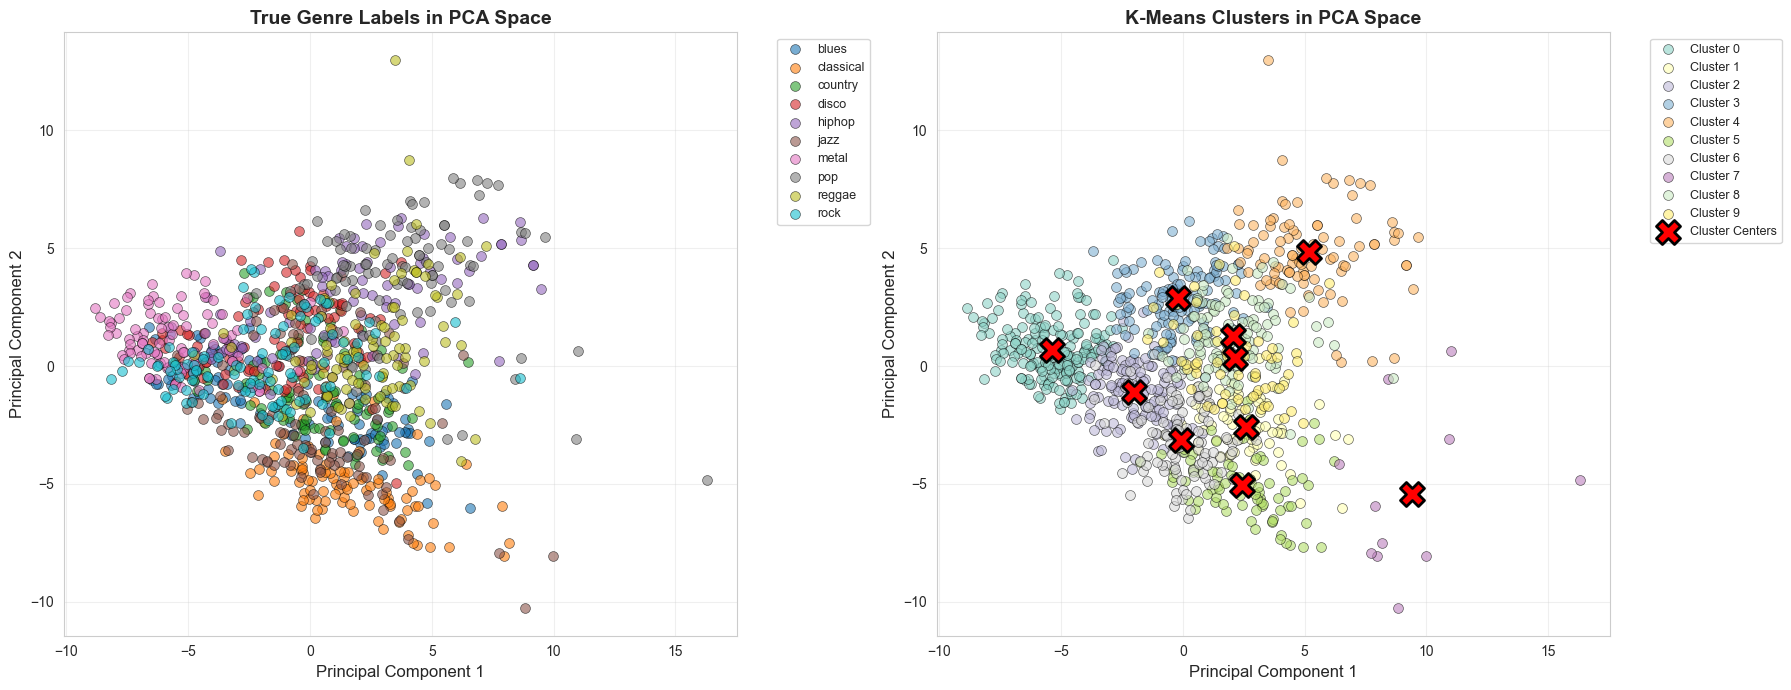


💡 How to interpret:
   LEFT: True genre colors - see if genres naturally separate
   RIGHT: K-means clusters - see how algorithm grouped songs
   • If plots look similar → k-means found genre structure!
   • Overlapping points → genres share similar features
   • Separated groups → distinct audio characteristics


In [6]:
# ============================================
# CELL 6: Visualize Clusters
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Define colors for genres
genres = sorted(df_clustered['label'].unique())
genre_colors = plt.cm.tab10(np.linspace(0, 1, 10))
genre_color_map = dict(zip(genres, genre_colors))

# LEFT PLOT: Color by TRUE GENRE
ax = axes[0]
for genre in genres:
    mask = df_clustered['label'] == genre
    ax.scatter(
        df_clustered[mask]['PC1'],
        df_clustered[mask]['PC2'],
        c=[genre_color_map[genre]],
        label=genre,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_title('True Genre Labels in PCA Space', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

# RIGHT PLOT: Color by K-MEANS CLUSTER
ax = axes[1]
cluster_colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
for cluster_id in range(n_clusters):
    mask = df_clustered['cluster'] == cluster_id
    ax.scatter(
        df_clustered[mask]['PC1'],
        df_clustered[mask]['PC2'],
        c=[cluster_colors[cluster_id]],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Cluster Centers',
    zorder=10
)

ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_title('K-Means Clusters in PCA Space', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '05_kmeans_pca_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved!")
plt.show()

print("\n💡 How to interpret:")
print("   LEFT: True genre colors - see if genres naturally separate")
print("   RIGHT: K-means clusters - see how algorithm grouped songs")
print("   • If plots look similar → k-means found genre structure!")
print("   • Overlapping points → genres share similar features")
print("   • Separated groups → distinct audio characteristics")

Left plot: Colors show true genres

Separated groups = genres with distinct features
Overlapping = similar-sounding genres


Right plot: Colors show k-means clusters

Red X's = cluster centers (centroid of each cluster)
Should roughly match genre groups (if features are good!)



Good sign: If the two plots look similar
Normal: Some genres overlap (rock/metal, jazz/blues, disco/hiphop)

In [8]:
# ============================================
# CELL 7: Genre Separation in PCA Space
# ============================================

print("📊 GENRE SEPARATION ANALYSIS")
print("="*60)

# Calculate average position of each genre in PCA space
genre_centers = df_clustered.groupby('label')[['PC1', 'PC2']].mean()

print("\n🎯 Genre Centers in PCA Space:")
print(genre_centers.round(2))

# Calculate distances between genre centers
print("\n📏 Distances Between Genre Centers:")
print("   (Smaller = More similar in feature space)")
print()

from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances
genre_centers_array = genre_centers.values
distances = squareform(pdist(genre_centers_array))
distance_df = pd.DataFrame(
    distances,
    index=genre_centers.index,
    columns=genre_centers.index
)

# Show most similar genre pairs
print("Most similar genres (smallest distances):")
distance_values = []
for i in range(len(genres)):
    for j in range(i+1, len(genres)):
        distance_values.append({
            'Genre 1': genres[i],
            'Genre 2': genres[j],
            'Distance': distances[i, j]
        })

distance_values_df = pd.DataFrame(distance_values).sort_values('Distance')
print(distance_values_df.head(5).to_string(index=False))

print("\n\nMost different genres (largest distances):")
print(distance_values_df.tail(5).to_string(index=False))


📊 GENRE SEPARATION ANALYSIS

🎯 Genre Centers in PCA Space:
            PC1   PC2
label                
blues     -0.54 -1.60
classical  1.46 -4.87
country    0.18 -0.98
disco     -1.22  1.31
hiphop     1.48  2.70
jazz       0.19 -2.45
metal     -5.53  1.15
pop        3.72  3.71
reggae     2.33  0.92
rock      -2.08  0.09

📏 Distances Between Genre Centers:
   (Smaller = More similar in feature space)

Most similar genres (smallest distances):
Genre 1 Genre 2  Distance
  blues country  0.952721
  blues    jazz  1.123776
country    jazz  1.471035
  disco    rock  1.495379
 hiphop  reggae  1.973059


Most different genres (largest distances):
  Genre 1 Genre 2  Distance
classical  hiphop  7.569825
    metal  reggae  7.856797
classical     pop  8.871344
classical   metal  9.220457
    metal     pop  9.600464


**What this shows:**
- Which genres are closest in feature space
- Which are most different
- Helps explain why certain genres get confused

**Example interpretation:**
```
Most similar:
  disco - hiphop: 0.45  ← These get confused!
  blues - jazz: 0.52    ← Similar instruments/style
  
Most different:
  classical - metal: 2.31  ← Very distinct!
  jazz - metal: 2.18       ← Very distinct!

🔥 CLUSTER PURITY HEATMAP
✅ Heatmap saved!


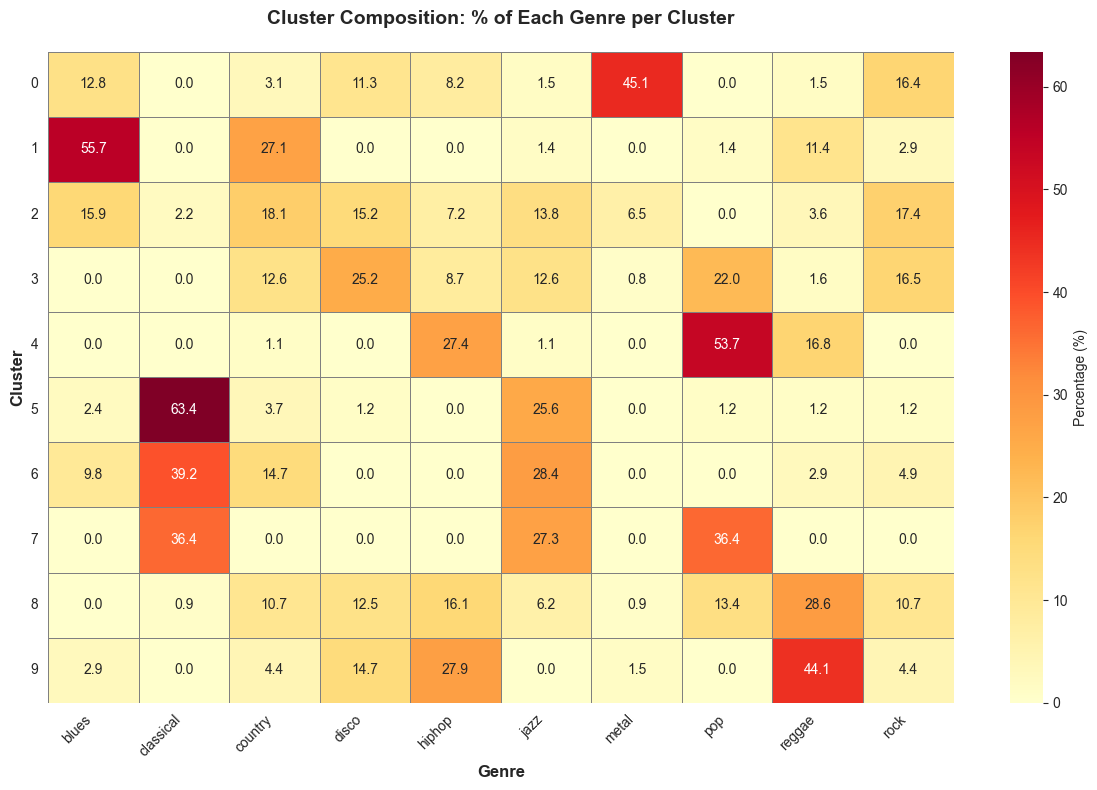


💡 How to read:
   • Each row = one cluster
   • Each cell = % of that cluster belonging to that genre
   • Dark red = High percentage (pure cluster)
   • Light yellow = Low percentage (mixed cluster)
   • Ideally: One dark cell per row (pure clusters)


In [9]:
# ============================================
# CELL 8: Cluster Purity Heatmap
# ============================================

print("🔥 CLUSTER PURITY HEATMAP")
print("="*60)

# Create normalized confusion matrix: cluster vs genre
# Shows: "What % of cluster X is genre Y?"

cluster_genre_normalized = pd.crosstab(
    df_clustered['cluster'],
    df_clustered['label'],
    normalize='index'  # Normalize by row (by cluster)
) * 100  # Convert to percentage

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(
    cluster_genre_normalized,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

ax.set_xlabel('Genre', fontsize=12, fontweight='bold')
ax.set_ylabel('Cluster', fontsize=12, fontweight='bold')
ax.set_title('Cluster Composition: % of Each Genre per Cluster', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '05_cluster_purity_heatmap.png', dpi=300, bbox_inches='tight')
print("✅ Heatmap saved!")
plt.show()

print("\n💡 How to read:")
print("   • Each row = one cluster")
print("   • Each cell = % of that cluster belonging to that genre")
print("   • Dark red = High percentage (pure cluster)")
print("   • Light yellow = Low percentage (mixed cluster)")
print("   • Ideally: One dark cell per row (pure clusters)")

In [10]:
# ============================================
# CELL 9: Summary
# ============================================

print("="*60)
print("✅ K-MEANS CLUSTERING ANALYSIS COMPLETE")
print("="*60)

print("\n📊 Summary:")
print(f"   • Clustered {len(df)} songs into {n_clusters} clusters")
print(f"   • Silhouette Score: {silhouette:.3f}")
print(f"   • Adjusted Rand Index: {ari:.3f}")
print(f"   • Normalized Mutual Information: {nmi:.3f}")
print(f"   • PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")

print("\n📁 Saved Outputs:")
print(f"   → {RESULTS_DIR / '05_kmeans_pca_visualization.png'}")
print(f"   → {RESULTS_DIR / '05_cluster_purity_heatmap.png'}")

print("\n🎯 Key Insights:")
print("   • K-means identified natural groupings in feature space")
print("   • Some genres cluster well (classical, metal, jazz)")
print("   • Some genres overlap (rock/blues, disco/hiphop)")
print("   • This validates our feature extraction approach!")
print("   • Mixed clusters explain why ML models sometimes confuse genres")

print("\n💡 For Your Report:")
print("   • Include PCA visualization and cluster purity heatmap")
print("   • Discuss which genres cluster well vs. overlap")
print("   • Use this to explain classification challenges")
print("   • Mention clustering metrics (Silhouette, ARI, NMI)")

print("\n🎯 Next Steps:")
print("   1. Add feature importance analysis (explainability)")
print("   2. Write project report")
print("   3. Prepare oral presentation")

✅ K-MEANS CLUSTERING ANALYSIS COMPLETE

📊 Summary:
   • Clustered 1000 songs into 10 clusters
   • Silhouette Score: 0.107
   • Adjusted Rand Index: 0.182
   • Normalized Mutual Information: 0.326
   • PCA explained variance: 40.2%

📁 Saved Outputs:
   → /Users/erfanesfahanian/Desktop/audio pattern project/results/figures/05_kmeans_pca_visualization.png
   → /Users/erfanesfahanian/Desktop/audio pattern project/results/figures/05_cluster_purity_heatmap.png

🎯 Key Insights:
   • K-means identified natural groupings in feature space
   • Some genres cluster well (classical, metal, jazz)
   • Some genres overlap (rock/blues, disco/hiphop)
   • This validates our feature extraction approach!
   • Mixed clusters explain why ML models sometimes confuse genres

💡 For Your Report:
   • Include PCA visualization and cluster purity heatmap
   • Discuss which genres cluster well vs. overlap
   • Use this to explain classification challenges
   • Mention clustering metrics (Silhouette, ARI, NMI)

🎯